# Test analysis

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
# import pandas as pd
import dask
# from wrf import to_np
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
from dask.distributed import Client
%matplotlib inline

In [2]:
# for quantreg
# from sklearn.linear_model import QuantileRegressor
from scipy import stats

In [3]:
from functions import ccplot, binning

In [4]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use(['science', 'notebook'])

In [5]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='YlGnBu')

In [6]:
# client = Client(n_workers=30, threads_per_worker=1, memory_limit='60GB')

### Import data

In [7]:
mfdata_DIR = './data/temporary/gpm*.nc'
    
gpm = xr.open_mfdataset(mfdata_DIR, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_mfdataset(mfdata_DIR, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_data/gpm_2000.nc', chunks={"time":2000})

In [8]:
gpm = gpm.unify_chunks()
gpm.chunks

Frozen({'time': (5000, 5000, 272, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2568), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [9]:
gpm

,Array,Chunk
Bytes,7.76 GiB,30.52 MiB
Shape,"(80400, 161, 161)","(5000, 40, 40)"
Count,955 Tasks,475 Chunks
Type,float32,numpy.ndarray


In [11]:
precip = gpm.precipCal.resample(time = '1H').mean()

In [12]:
precip = precip.chunk(dict(time=5000, lat=40, lon=40))

In [13]:
precip = precip.unify_chunks()
precip.chunks

((5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 200),
 (40, 40, 40, 40, 1),
 (40, 40, 40, 40, 1))

In [14]:
precip

<xarray.DataArray 'precipCal' (time: 40200, lat: 161, lon: 161)>
dask.array<rechunk-merge, shape=(40200, 161, 161), dtype=float32, chunksize=(5000, 40, 40), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
  * lon      (lon) float64 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * lat      (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0

In [15]:
mfdata_DIR2 = './data/temporary/era*.nc'

era = xr.open_mfdataset(mfdata_DIR2, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [16]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    era = era.reindex(latitude = era.latitude[::-1])

In [17]:
era = era.sel(time = slice("2000-06-01 00:00:00","2004-12-31 23:00:00"))

In [18]:
era = era.unify_chunks()
era.chunks

Frozen({'time': (1352, 3784, 5000, 3760, 5000, 3760, 5000, 3760, 5000, 3784), 'latitude': (161,), 'longitude': (161,)})

In [19]:
era

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 161, time: 40200)
Coordinates:
  * latitude   (latitude) float32 0.0 0.25 0.5 0.75 ... 39.25 39.5 39.75 40.0
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [20]:
# era = era.sel(expver=1, drop=True)

In [21]:
# era.coords['latitude'] = np.flip(era.coords['latitude']

In [22]:
era = era.transpose('time', 'latitude', 'longitude')

In [23]:
# era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})

In [24]:
era = era.rename({'longitude':'lon', 'latitude':'lat'})

In [25]:
era

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 161, time: 40200)
Coordinates:
  * lat      (lat) float32 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [26]:
t2m = era.t2m
d2m = era.d2m

In [27]:
t2m = t2m.chunk(dict(time=5000, lat=40, lon=40))
d2m = d2m.chunk(dict(time=5000, lat=40, lon=40))

In [28]:
ds_comb = xr.merge([precip, t2m, d2m])

In [29]:
ds_comb

<xarray.Dataset>
Dimensions:    (time: 40200, lon: 161, lat: 161)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 ... 2004-12-31T23:00:00
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(5000, 40, 40), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(5000, 40, 40), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(5000, 40, 40), meta=np.ndarray>

In [30]:
# ds_comb.to_netcdf('./data/combined/ds_comb2.nc')

In [31]:
# del gpm
# del era
# del t2m
# del precip
# del d2m
# del ds_comb

## Binning

In [7]:
ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

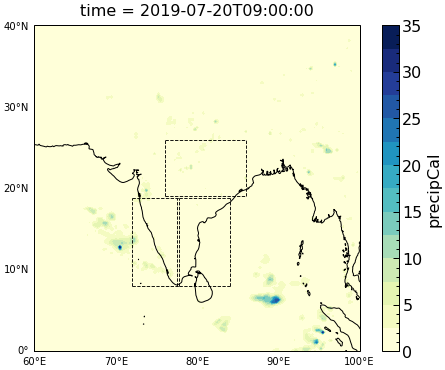

In [8]:
# fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([59.9, 100.1, -0.1, 40.1], crs=ccrs.PlateCarree())
# marking wcgw
ax.plot([72, 72], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([77.75, 77.75], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([72, 77.75], [8, 8], 'k', ls = '--', lw=0.9)
ax.plot([72, 77.75], [18.75, 18.75], 'k', ls = '--', lw = 0.9)
# marking sip region
ax.plot([77.5, 77.5], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([84, 84], [8, 18.75], 'k', ls = '--', lw = 0.9)
ax.plot([77.75, 84], [8, 8], 'k', ls = '--', lw=0.9)
ax.plot([77.75, 84], [18.75, 18.75], 'k', ls = '--', lw = 0.9)
# marking cir region
ax.plot([76, 76], [19, 26], 'k', ls = '--', lw = 0.9)
ax.plot([86, 86], [19, 26], 'k', ls = '--', lw = 0.9)
ax.plot([76, 86], [19, 19], 'k', ls = '--', lw=0.9)
ax.plot([76, 86], [26, 26], 'k', ls = '--', lw = 0.9)
ds_comb.precipCal.sel(time="2019-07-20 09:00:00").plot.contourf(ax = ax, extend='neither', levels=15)
# ax.coastlines(alpha=0.7)
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
# ax.add_feature(cfeature.BORDERS, alpha=0.7)
ax.add_feature(cfeature.COASTLINE, alpha=1.0)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False
# ax.tick_params(axis='both', labelsize=12)
plt.savefig('./images/region.pdf', dpi=300)

**Getting the the monsoon data from all years**

In [9]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [10]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i-1][1] for i in mon], dim='time')

In [11]:
ds_comb_mon

<xarray.Dataset>
Dimensions:    (lon: 161, lat: 161, time: 8784)
Coordinates:
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2017-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipCal  (time, lat, lon) float32 0.0 0.006299 0.0 0.0 ... 0.0 0.0 0.0 0.0
    t2m        (time, lat, lon) float32 301.7 301.6 301.6 ... 285.5 285.6 285.8
    d2m        (time, lat, lon) float32 296.7 296.7 296.8 ... 271.5 271.0 270.8

**analysing**

In [12]:
precip = ds_comb_mon.precipCal
t2m = ds_comb_mon.t2m
d2m = ds_comb_mon.d2m

In [13]:
precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

In [14]:
# Set values less than 1 mm/hr to nan

precip = xr.where(precip_daily_rate > 1, precip, np.nan).chunk(dict(time=-1, lat=40, lon=40))
precip = precip.where(precip > 0).chunk(dict(time=-1, lat=40, lon=40))
# precip = xr.where(precip > 0.1, precip, np.nan).chunk(dict(time=-1, lat=40, lon=40))
t2m = t2m.where(precip != np.nan).chunk(dict(time=-1, lat=40, lon=40))
d2m = d2m.where(precip != np.nan).chunk(dict(time=-1, lat=40, lon=40))

In [ ]:
# ds_comb_new = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1, lat=40, lon=40))
# ds_comb_new

In [ ]:
# ds_comb_new.unify_chunks()
# ds_comb_new.chunks

### India plots

In [ ]:
# ind_precip = precip.chunk(dict(time=-1, lat=40, lon=40))
# ind_t2m = t2m.chunk(dict(time=-1, lat=40, lon=40))
# ind_d2m = d2m.chunk(dict(time=-1, lat=40, lon=40))

In [ ]:
# wg.unify_chunks()
# wg_precip.chunks

In [ ]:
# wg = wg.rename_vars({'precipCal':'precipitationCal'})

In [ ]:
# del ds_comb
# del ds_comb_mon
# del mum

In [ ]:
# preciparr = precip.to_numpy()
# t2marr = t2m.to_numpy()
# d2marr = d2m.to_numpy()

In [19]:
ccscale95_t2m_slope, ccscale95_t2m_p, ccscale95_d2m_slope, ccscale95_d2m_p  = binning.get_binned_3d_alter(precip, t2m, d2m, percentile_val=0.95, bin_nr=12)

Starting the binning process ...
Getting the equal freq bins ...
Inititalising the arrays ...
Done, now starting the loop ...
Completed 0/161 lat and 0/161 lon
Completed 0/161 lat and 1/161 lon
Completed 0/161 lat and 2/161 lon
Completed 0/161 lat and 3/161 lon
Completed 0/161 lat and 4/161 lon
Completed 0/161 lat and 5/161 lon
Completed 0/161 lat and 6/161 lon
Completed 0/161 lat and 7/161 lon
Completed 0/161 lat and 8/161 lon
Completed 0/161 lat and 9/161 lon


KeyboardInterrupt: 

In [ ]:
!date

In [ ]:
# ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(ind_precip, ind_t2m, ind_d2m, percentile_val=0.50, bin_nr=20)

In [78]:
# # Plotting function -- Fpr India
# def ccplot_3d(slope_da, r_da, extent_list, title, threshold_sig=0.95, marker_size=2, **kwargs):
#     """
#     Function to plot the output of binning 3d function
#     -----
#     inputs are -
#     slope_da : datarray containing slope
#     r_da : datarray containing R^2 values for goodness of fit
#     title : The title of the output plot
#     extent_list : [59.9, 100.1, -0.1, 40.1]
#     """
#     ax = plt.axes(projection=ccrs.PlateCarree())
#     ax.set_extent(extent_list, crs=ccrs.PlateCarree())
#     (100*(np.exp(slope_da) - 1)).plot.contourf(ax = ax, cbar_kwargs={"label":"C-C scale"}, **kwargs)
# #     (100*(np.exp(slope_da) - 1)).plot.pcolormesh(ax = ax, cbar_kwargs={"label":"C-C scale"}, **kwargs)
#     x, y = np.meshgrid(slope_da.coords['lon'], slope_da.coords['lat'])
#     plt.scatter(x[(np.abs(r_da.to_numpy()) > threshold_sig)],y[(np.abs(r_da.to_numpy()) > threshold_sig)], marker='o', color = 'k', s=marker_size)
#     gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
#     # ax.coastlines(alpha=0.7)
#     # ax.add_feature(cfeature.BORDERS, alpha=0.7)
#     ax.add_feature(cfeature.COASTLINE, alpha=1.0)
#     gridliner.top_labels = False
#     gridliner.right_labels = False
#     gridliner.ylines = False  # you need False
#     gridliner.xlines = False  # you need False
#     ax.set_title(title)
#     # ax.set_xlabel('Latitude')
#     # ax.set_ylabel('Longitude')
#     # ax.tick_params(axis='both', labelsize=12)
# # ax.tick_params(axis='both', labelsize=12)

In [46]:
# Extent_lists
ind = [59.9, 100.1, -0.1, 40.1]
sip = [77.65, 84.1, 7.9, 18.85]
wcwg = [71.9, 77.15, 7.9, 18.85]
cir = [75.9, 86.1, 18.9, 26.1]

In [47]:
t2m_slope = xr.DataArray(ccscale95_t2m_slope, dims=("lat", "lon"), coords={"lat": precip.coords['lat'], "lon": precip.coords['lon']}, attrs=dict(description="C-C scale", units="degC$^{-1}$"))

t2m_p = xr.DataArray(ccscale95_t2m_p, dims=("lat", "lon"), coords={"lat": precip.coords['lat'], "lon": precip.coords['lon']}, attrs=dict(description="C-C scale", units="degC$^{-1}$"))

d2m_slope = xr.DataArray(ccscale95_d2m_slope, dims=("lat", "lon"), coords={"lat": precip.coords['lat'], "lon": precip.coords['lon']}, attrs=dict(description="C-C scale", units="degC$^{-1}$"))

d2m_p = xr.DataArray(ccscale95_d2m_p, dims=("lat", "lon"), coords={"lat": precip.coords['lat'], "lon": precip.coords['lon']}, attrs=dict(description="C-C scale", units="degC$^{-1}$"))

In [48]:
t2m_slope.isnull().sum()

<xarray.DataArray ()>
array(25921)

/home/nkv/.miniconda/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/nkv/.miniconda/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


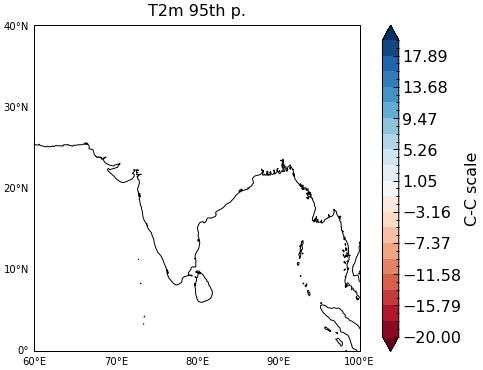

In [49]:
# India T2m 99th
ccplot.plot_3d(t2m_slope, t2m_p, ind, 'T2m 95th p.', threshold_sig=0.001, marker_size=.02, levels=20, extend='both', vmax=20, center=0.0)
# plt.savefig('./images/india_t2m95.pdf', dpi=300)

/home/nkv/.miniconda/lib/python3.9/site-packages/matplotlib/contour.py:1486: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/nkv/.miniconda/lib/python3.9/site-packages/matplotlib/contour.py:1487: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


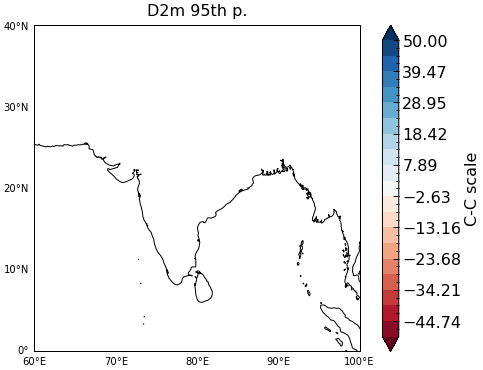

In [32]:
# Wester Ghats D2m 99th
ccplot.plot_3d(d2m_slope, d2m_p, ind, 'D2m 95th p.', threshold_sig=0.001, marker_size=.02, levels=20, extend='both', vmax=50, center=0.0)
# plt.savefig('./images/india_d2m95.pdf', dpi=300)

In [247]:
# ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(wg_precip, wg_t2m, wg_d2m, percentile_val=0.50, bin_nr=20)

In [63]:
# # India T2m 50th
# ccplot.plot_3d(ccscale50_t2m_slope, ccscale50_t2m_p, 'WG T2m 50th p.', [73.65, 76.35, 9.9, 20.1], levels=20)
# plt.savefig('./images/wg_t2m50.pdf', dpi=300)

In [64]:
# # India D2m 50th
# ccplot.plot_3d(ccscale50_d2m_slope, ccscale50_d2m_p, 'WG D2m 50th p.',[73.65, 76.35, 9.9, 20.1], levels=20, vmin=-1, vmax=1.0, extend='max')
# plt.savefig('./images/wg_d2m50.pdf', dpi=300)

## SIP region

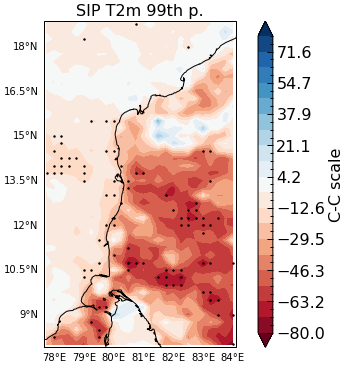

In [104]:
ccplot_3d(ccscale95_t2m_slope.sel(lat =slice(8,19), lon = slice(77.75,84)), ccscale95_t2m_p.sel(lat =slice(8,19), lon = slice(77.75,84)), sip, 'SIP T2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=80, center=0.0)
plt.savefig('./images/sip_t2m95.pdf', dpi=300)

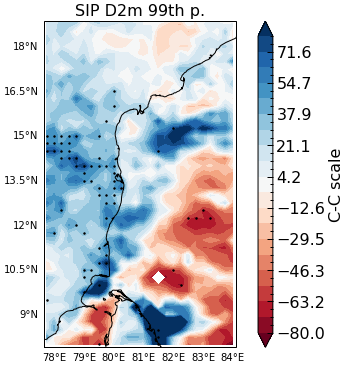

In [105]:
ccplot_3d(ccscale95_d2m_slope.sel(lat =slice(8,19), lon = slice(77.75,84)), ccscale95_d2m_p.sel(lat =slice(8,19), lon = slice(77.75,84)), sip, 'SIP D2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=80, center=0.0)
plt.savefig('./images/sip_d2m95.pdf', dpi=300)

## WCWG region

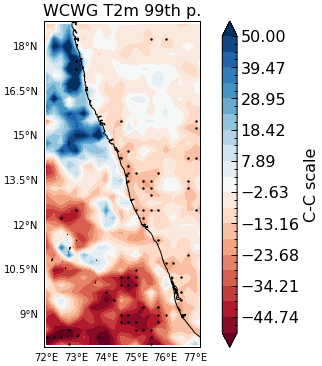

In [106]:
ccplot_3d(ccscale95_t2m_slope.sel(lat =slice(8,18.75), lon = slice(72,77.5)), ccscale95_t2m_p.sel(lat =slice(8,18.75), lon = slice(72,77.5)), wcwg, 'WCWG T2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=50, center=0.0)
plt.savefig('./images/wcwg_t2m95.pdf', dpi=300)

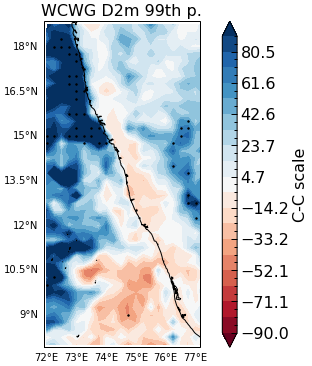

In [107]:
ccplot_3d(ccscale95_d2m_slope.sel(lat =slice(8,18.75), lon = slice(72,77.5)), ccscale95_d2m_p.sel(lat =slice(8,18.75), lon = slice(72,77.5)), wcwg, 'WCWG D2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=90, center=0.0)
plt.savefig('./images/wcwg_d2m95.pdf', dpi=300)

## CIR region

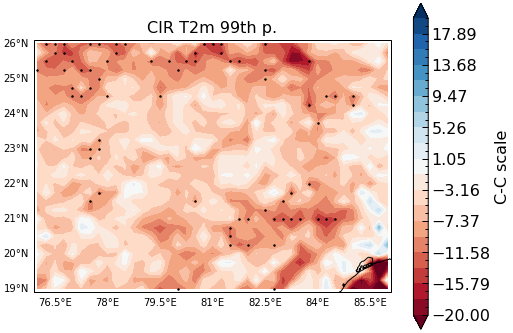

In [110]:
ccplot_3d(ccscale95_t2m_slope.sel(lat =slice(19,26), lon = slice(76,86)), ccscale95_t2m_p.sel(lat =slice(19,26), lon = slice(76,86)), cir, 'CIR T2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=20, center=0.0)
plt.savefig('./images/cir_t2m95.pdf', dpi=300)

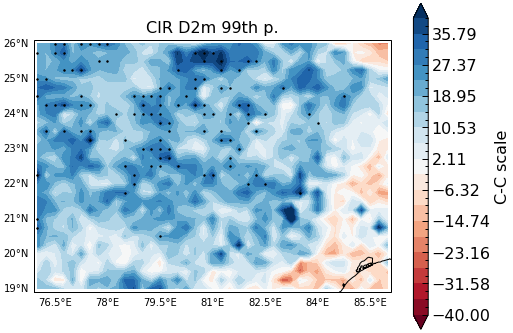

In [116]:
ccplot_3d(ccscale95_d2m_slope.sel(lat =slice(19,26), lon = slice(76,86)), ccscale95_d2m_p.sel(lat =slice(19,26), lon = slice(76,86)), cir, 'CIR D2m 95th p.', threshold_sig=0.8, marker_size=2, levels=20, extend='both', vmax=40, center=0.0)
plt.savefig('./images/cir_d2m95.pdf', dpi=300)

### Western Ghats

In [16]:
# Western Ghats mean
# mum = ds_comb_new.sel(lat=slice(10,20), lon = slice(73.75,76.25)).mean(dim = ['lat', 'lon'])
precip_wg = precip.sel(lat=slice(8,20), lon = slice(72,78)).mean(dim = ['lat', 'lon'])
t2m_wg = t2m.sel(lat=slice(8,20), lon = slice(72,78)).mean(dim = ['lat', 'lon'])
d2m_wg = d2m.sel(lat=slice(8,20), lon = slice(72,78)).mean(dim = ['lat', 'lon'])

In [43]:
precip_ind = precip.mean(dim = ['lat', 'lon'])
t2m_ind = t2m.mean(dim = ['lat', 'lon'])
d2m_ind = d2m.mean(dim = ['lat', 'lon'])

In [ ]:
# mum.chunks

In [44]:
binned_precip95_t2m, mean_temp95_t2m = binning.get_binned(precip_ind, t2m_ind, percentile_val=0.95, bin_nr=20)
binned_precip50_t2m, mean_temp50_t2m = binning.get_binned(precip_ind, t2m_ind, percentile_val=0.50, bin_nr=20)

In [45]:
binned_precip95_d2m, mean_temp95_d2m = binning.get_binned(precip_ind, d2m_ind, percentile_val=0.95, bin_nr=20)
binned_precip50_d2m, mean_temp50_d2m = binning.get_binned(precip_ind, d2m_ind, percentile_val=0.50, bin_nr=20)

In [46]:
binned_precip50_d2m

<xarray.DataArray 'precipCal' (d2m_bins: 20)>
dask.array<getitem, shape=(20,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * d2m_bins  (d2m_bins) object (288.23959350580003, 289.3819458008] ... (292...
    quantile  float64 0.5

In [57]:
# for t2m
temparr95, preciparr1_95, preciparr2_95 = ccplot.get_ideal_data(mean_temp95_t2m, 0.1, 1, time_scale=1)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mean_temp50_t2m, 0.06, 0.6, time_scale=1)

In [58]:
# for t2m
temparr95, preciparr3_95, preciparr4_95 = ccplot.get_ideal_data(mean_temp95_t2m, 0.0001, 0.001, time_scale=2)
temparr50, preciparr3_50, preciparr4_50 = ccplot.get_ideal_data(mean_temp50_t2m, 0.0001, 0.001, time_scale=2)

In [50]:
# for d2m
temparr95, preciparr1_95, preciparr2_95 = ccplot.get_ideal_data(mean_temp95_d2m, 0.1, 1, time_scale=1)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mean_temp50_d2m, 0.05, 0.6, time_scale=1)

In [51]:
# for d2m
temparr95, preciparr3_95, preciparr4_95 = ccplot.get_ideal_data(mean_temp95_d2m, 0.0001, 0.001, time_scale=2)
temparr50, preciparr3_50, preciparr4_50 = ccplot.get_ideal_data(mean_temp50_d2m, 0.0002, 0.003, time_scale=2)

In [22]:
# binned_ds99 = binned_ds99.rename_vars({'precipCal':'precipitationCal'})
# binned_ds50 = binned_ds50.rename_vars({'precipCal':'precipitationCal'})

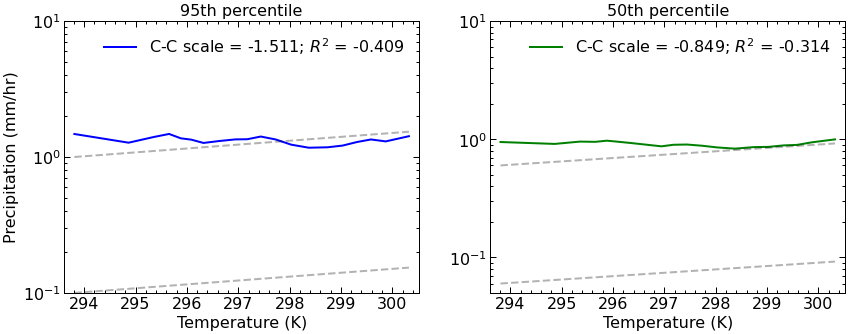

In [59]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(binned_precip95_t2m, mean_temp95_t2m, temparr95, preciparr1_95, preciparr2_95, preciparr3_95, preciparr4_95, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('95th percentile')
plt.ylim(0.1, 10)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(binned_precip50_t2m, mean_temp50_t2m, temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.ylim(0.05, 5)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')
# fig.tight_layout()
plt.savefig('./images/ind_ccplot_t2m_small.pdf', dpi = 300)

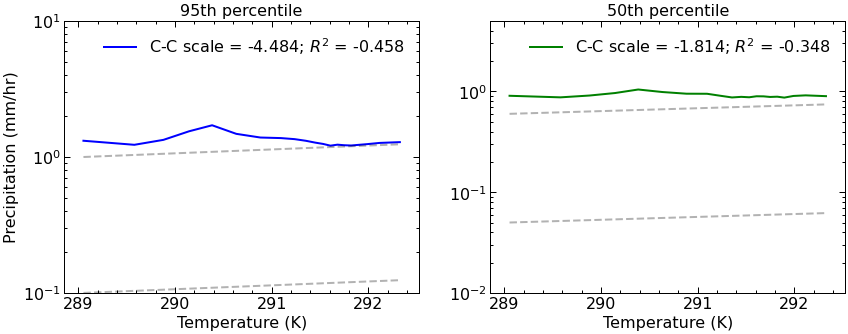

In [55]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(binned_precip95_d2m, mean_temp95_d2m, temparr95, preciparr1_95, preciparr2_95, preciparr3_95, preciparr4_95, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('95th percentile')
plt.ylim(0.1, 10)
# plt.xlim(294.8, 297)
plt.yticks([0.1, 1, 10])

# fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(binned_precip50_d2m, mean_temp50_d2m, temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.ylim(0.01, 5)
# plt.xlim(294.8, 297)
plt.yticks([0.01, 0.1, 1])

# fig.gca().yaxis.set_ticks_position('both')
# fig.tight_layout()
plt.savefig('./images/ind_ccplot_d2m_small.pdf', dpi = 300)

In [43]:
wg_precip = precip.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))
wg_t2m = t2m.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))
wg_d2m = d2m.sel(lat = slice(10, 20), lon = slice(73.75, 76.25)).chunk(dict(time=-1, lat=-1, lon=-1))

In [44]:
# wg.unify_chunks()
# wg_precip.chunks

In [45]:
# wg = wg.rename_vars({'precipCal':'precipitationCal'})

In [46]:
# del ds_comb
# del ds_comb_mon
# del mum

In [47]:
wg_d2m

<xarray.DataArray 'd2m' (time: 26280, lat: 41, lon: 11)>
dask.array<rechunk-merge, shape=(26280, 41, 11), dtype=float32, chunksize=(26280, 41, 11), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 73.75 74.0 74.25 74.5 74.75 ... 75.5 75.75 76.0 76.25
  * lat      (lat) float64 10.0 10.25 10.5 10.75 11.0 ... 19.25 19.5 19.75 20.0
  * time     (time) datetime64[ns] 2017-01-01 ... 2019-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre dewpoint temperature

In [49]:
ccscale99_t2m_slope, ccscale99_t2m_p, ccscale99_d2m_slope, ccscale99_d2m_p  = binning.get_binned_3d(wg_precip, wg_t2m, wg_d2m, percentile_val=0.99, bin_nr=20)

/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/nkv/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfu

KeyboardInterrupt: 

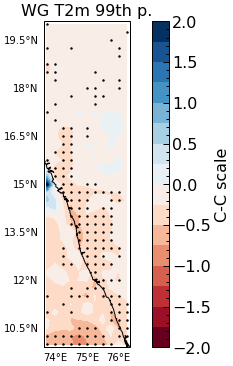

In [35]:
# Wester Ghats T2m 99th
ccplot.plot_3d(ccscale99_t2m_slope, ccscale99_t2m_p, [73.65, 76.35, 9.9, 20.1], 'WG T2m 99th p.', threshold_sig = 0.8, makrker_size=2, levels=20)
plt.savefig('./images/wg_t2m99.pdf', dpi=300)

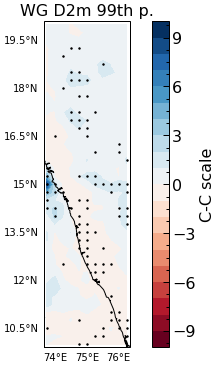

In [36]:
# Wester Ghats D2m 99th
ccplot.plot_3d(ccscale99_d2m_slope, ccscale99_t2m_p, [73.65, 76.35, 9.9, 20.1], 'WG D2m 99th p.', threshold_sig = 0.8, makrker_size=2, levels=20)
plt.savefig('./images/wg_d2m99.pdf', dpi=300)

In [37]:
ccscale50_t2m_slope, ccscale50_t2m_p, ccscale50_d2m_slope, ccscale50_d2m_p  = binning.get_binned_3d(wg_precip, wg_t2m, wg_d2m, percentile_val=0.50, bin_nr=20)

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in log
  slope, _, r, _, _ = stats.linregress(x, np.log(y))
/home/nkv/.miniconda/lib/python3.9/site-packages/numpy/lib/function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/mnt/f/msc_project/functions/binning.py:28: RuntimeWarning: divide by zero encountered in l

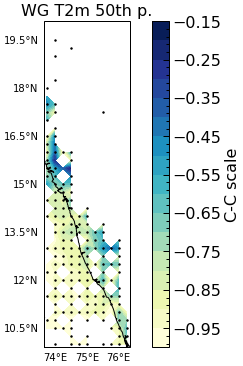

In [38]:
# Wester Ghats T2m 50th
ccplot.plot_3d(ccscale50_t2m_slope, ccscale50_t2m_p, [73.65, 76.35, 9.9, 20.1], 'WG T2m 50th p.', threshold_sig = 0.8, makrker_size=2, levels=20)
plt.savefig('./images/wg_t2m50.pdf', dpi=300)

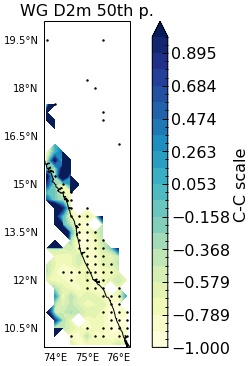

In [39]:
# Wester Ghats D2m 50th
ccplot.plot_3d(ccscale50_d2m_slope, ccscale50_d2m_p, [73.65, 76.35, 9.9, 20.1], 'WG D2m 50th p.', threshold_sig = 0.8, makrker_size=2, levels=20)
plt.savefig('./images/wg_d2m50.pdf', dpi=300)